In [1]:
########### IMPORT MODULES ########### 

# GENERAL THINGS FOR COMPUTING AND PLOTTING
import pandas as pd
import numpy as np
import os, sys, time

# visualisation
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set(style="darkgrid", context="talk")

# ibl specific things
import datajoint as dj
from ibl_pipeline import reference, subject, action, acquisition, data, behavior
from ibl_pipeline.analyses import behavior as behavioral_analyses


# set path for saving figures
figpath  = os.path.join(os.path.expanduser('~'), 'Documents/Google Drive File Stream/O meu disco/Ines - IBL/Analysis/CA')

Connecting anneurai@datajoint.internationalbrainlab.org:3306


In [2]:
########### SUBJECTS ########### 

subj = subject.Subject * subject.SubjectLab * subject.SubjectProject & 'subject_project = "collab_citricacid"' & 'lab_name="mainenlab"'

In [3]:
########### WATER ADMINISTRATIONS ########### 

water_with_date = (action.WaterAdministration & subj).proj('watertype_name', 'water_administered', 'adlib', # it can restrict on the subj here but it will anyway do later
                                                  session_date='DATE(administration_time)')
water_date = (dj.U('subject_uuid', 'session_date') & water_with_date) & 'session_date < "2018-10-24"'& 'session_date > "2018-10-05"'
total_water_date = water_date.aggr(water_with_date, total_water='SUM(water_administered)', 
                                   watertype="GROUP_CONCAT(DISTINCT watertype_name SEPARATOR '; ')", 
                                   adlib='MAX(adlib)')
b = subj * total_water_date # including water will exclude mice with ad lib water

df = pd.DataFrame(b.fetch(as_dict=True))
df.tail(n=10)

,subject_uuid,subject_project,session_date,subject_nickname,sex,subject_birth_date,ear_mark,subject_line,subject_source,protocol_number,subject_description,subject_ts,lab_name,subjectlab_ts,subjectproject_ts,total_water,watertype,adlib
194,f8f2ec95-bc15-4c72-bf93-74185cbd049f,collab_citricacid,2018-10-09,ZM_338,M,2018-08-08,None,None,CCU - Margarida colonies,1,None,2019-09-25 01:33:41,mainenlab,2019-08-06 21:41:41,2019-09-26 12:30:21,0.71,Water,0
195,f8f2ec95-bc15-4c72-bf93-74185cbd049f,collab_citricacid,2018-10-11,ZM_338,M,2018-08-08,None,None,CCU - Margarida colonies,1,None,2019-09-25 01:33:41,mainenlab,2019-08-06 21:41:41,2019-09-26 12:30:21,0.73,Water,0
196,f8f2ec95-bc15-4c72-bf93-74185cbd049f,collab_citricacid,2018-10-12,ZM_338,M,2018-08-08,None,None,CCU - Margarida colonies,1,None,2019-09-25 01:33:41,mainenlab,2019-08-06 21:41:41,2019-09-26 12:30:21,0.73,Water,0
197,f8f2ec95-bc15-4c72-bf93-74185cbd049f,collab_citricacid,2018-10-13,ZM_338,M,2018-08-08,None,None,CCU - Margarida colonies,1,None,2019-09-25 01:33:41,mainenlab,2019-08-06 21:41:41,2019-09-26 12:30:21,1.46,Water,0
198,f8f2ec95-bc15-4c72-bf93-74185cbd049f,collab_citricacid,2018-10-15,ZM_338,M,2018-08-08,None,None,CCU - Margarida colonies,1,None,2019-09-25 01:33:41,mainenlab,2019-08-06 21:41:41,2019-09-26 12:30:21,0.73,Water,0
199,f8f2ec95-bc15-4c72-bf93-74185cbd049f,collab_citricacid,2018-10-16,ZM_338,M,2018-08-08,None,None,CCU - Margarida colonies,1,None,2019-09-25 01:33:41,mainenlab,2019-08-06 21:41:41,2019-09-26 12:30:21,0.73,Water,0
200,f8f2ec95-bc15-4c72-bf93-74185cbd049f,collab_citricacid,2018-10-17,ZM_338,M,2018-08-08,None,None,CCU - Margarida colonies,1,None,2019-09-25 01:33:41,mainenlab,2019-08-06 21:41:41,2019-09-26 12:30:21,0.75,Water,0
201,f8f2ec95-bc15-4c72-bf93-74185cbd049f,collab_citricacid,2018-10-19,ZM_338,M,2018-08-08,None,None,CCU - Margarida colonies,1,None,2019-09-25 01:33:41,mainenlab,2019-08-06 21:41:41,2019-09-26 12:30:21,0.77,Water,0
202,f8f2ec95-bc15-4c72-bf93-74185cbd049f,collab_citricacid,2018-10-20,ZM_338,M,2018-08-08,None,None,CCU - Margarida colonies,1,None,2019-09-25 01:33:41,mainenlab,2019-08-06 21:41:41,2019-09-26 12:30:21,1.55,Water,0
203,f8f2ec95-bc15-4c72-bf93-74185cbd049f,collab_citricacid,2018-10-22,ZM_338,M,2018-08-08,None,None,CCU - Margarida colonies,1,None,2019-09-25 01:33:41,mainenlab,2019-08-06 21:41:41,2019-09-26 12:30:21,0.77,Water,0


In [4]:
########### CONDITIONS ########### 

# CTL = free water regime (control)
# CA = ad libitum citric acid water
# FA = fixed amount of water per day (600 uL per weekday and 1 mL per weekend)
# CA = calculated amount (40 uL/g/day)

CA = '2% Citric Acid'
WD = 'Weight-based amount'
FA = 'Fixed amount'
CTL = 'Free water'

condition_map = {'6867': CA, '6869':CA, 'ZM_209':CA, '6872':CA, 'ZM_342':CA,
'ZM_202':FA, 'ZM_337':FA, 'ZM_206':FA, 'ZM_208':FA, 
'ZM_203':WD, 'ZM_210':WD, 'ZM_338':WD, '6870':WD,
'ZM_205':CTL, 'ZM_335':CTL, '6873':CTL, 'ZM_200':CTL}

df['condition'] = df.subject_nickname.map(condition_map)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/urai/Documents/Google Drive File Stream/O meu disco/Ines - IBL/Analysis/CA/consumed_water_boxplot.pdf'

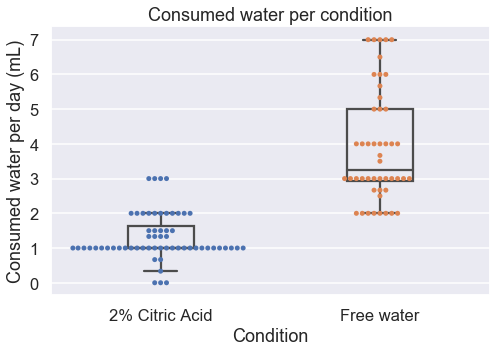

In [5]:
########### PLOTS ########### 

f = plt.figure(figsize=(7,5))
ax = sns.swarmplot(x="condition", y="total_water", order=['2% Citric Acid', 'Free water'], 
data=df)
sns.boxplot(x="condition", y="total_water", order=['2% Citric Acid', 'Free water'], 
data=df, fliersize=0, boxprops={'facecolor':'None'}, width=.3)
plt.ylabel("Consumed water per day (mL)")         
plt.xlabel("Condition")
plt.title("Consumed water per condition")
f.tight_layout()
f.savefig(os.path.join(figpath, "consumed_water_boxplot.pdf"))